In [1]:
%matplotlib inline
import pykat
import pylab as pl
import numpy as np

### My functions
from kat_commands import *
from cav_commands import *
from MMT import modematch

import get_WS
import trace_mode
import Find_Modes

                                              ..-
    PyKat 1.0.19          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat"
maxtem = 2  

In [3]:
#perfect mode matching no squeezing for a reference
basekat0 = pykat.finesse.kat() 
basekat0.loadKatFile(katfile)
basekat0.parseCommands(darm_commands)
basekat0.parseCommands(cav_commands_FC_last)
basekat0.parseCommands("maxtem "+str(maxtem))
basekat0.undumpNodes() #undump the vacuum nodes
kat0=basekat0.deepcopy() #copy kat code
kat0.verbose = False

out_perfect_mm_nosqz = kat0.run()

Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line.


In [4]:
#load the original kat file (ie Perfect Modematching) as a reference w squeezing
kat1=kat0.deepcopy()
kat1.parseCommands(add_squeezing)
kat1.verbose = False

out_perfect_mm = kat1.run()

In [11]:
### Building an ideal MM telescope between SRC and OMC so that you can MM OMC to ARMS

###Extract the eigenmode of SRC with offsets in SR3
###
SR3_Rc_orig = kat1.SR3.Rc.value
max_offset_SR3 = .01634 #95% Roc change in SR3 curvature

#Add Commands
basekat2 = pykat.finesse.kat() 
basekat2.loadKatFile(katfile)
basekat2.parseCommands(commands)
basekat2.parseCommands(cav_commands_FC_last)
kat2=basekat2.deepcopy() 
kat2.verbose = False

# Change the SR3_HR RoC
SR3_Rc_new = SR3_Rc_orig + max_offset_SR3
kat2.SR3.Rcx.value = SR3_Rc_new
kat2.SR3.Rcy.value = SR3_Rc_new

#### Extract the mode at the SRMAR w.r.t the ARM
[get_SRM_qx_wrt_cavARM,get_SRM_qy_wrt_cavARM] = trace_mode.from_cav_to_node(kat2,'cavXARM','nSRMARb')

#### Extract the mode at the OFI w.r.t the OMC
[get_OFI_qx_wrt_OMC,get_OFI_qy_wrt_OMC] = trace_mode.from_cav_to_node(kat2,'cavOMC','nIBAin')

################## Implement the telescope to MM the ARMS to OMC while changing SRC
basekat2 = pykat.finesse.kat() 
basekat2.loadKatFile(katfile)
basekat2.parseCommands(darm_commands)
basekat2.parseCommands(amplitude_detectors)
basekat2.parseCommands(add_squeezing)
basekat2.parseCommands(cav_commands_FC_last)
basekat2.parseCommands("maxtem "+str(maxtem))
basekat2.parseCommands("maxtem 4")
basekat2.parseCommands("""
bp q_sqz_x x q nsqz
bp q_sqz_y y q nsqz
""")
basekat2.undumpNodes()
kat2=basekat2.deepcopy()
kat2.verbose = False

SR3_Rc = SR3_Rc_orig
dRc = max_offset_SR3
    
kat2.SR3.Rcx.value = SR3_Rc + dRc
kat2.SR3.Rcy.value = SR3_Rc + dRc

#
#    q1   d1   f1  d2   f2  d3   q2
#    |   <-->  |  <-->  | <-->  |
#    | <---------- D ---------> |
#

q1 = get_SRM_qx_wrt_cavARM
q2 = -np.conjugate(get_OFI_qx_wrt_OMC)
D  = 0.491516 # total distance from SRC to OFI
d1 = 0.25
d2 = 0.0001
d3 = D-d1-d2

[f1, f2] = modematch(q1, q2, d1, d2, d3)

kat2.lSRMTT1.L.value = d1
kat2.SRMTT1.f.value = f1
kat2.lSRMTT2.L.value = d2
kat2.SRMTT2.f.value = f2
kat2.lIBAin.L.value = d3

# Get the q at the sqzer
out_varySR3 = kat2.run()

##### Testing to trace the modes

kat_findmode = kat2.deepcopy()
mode_dict = Find_Modes.find_all(kat_findmode,out_varySR3_FCswp["q_sqz_x"][0],out_varySR3_FCswp["q_sqz_y"][0])

Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line.
Parsing `dbs OPP nOPb nOPc nOPd nOPz` into pykat object not implemented yet, added as extra line.
Successfully Mode-Matched! >99.9% overlap
f1 is 0.0014957533754647028
f2 is -0.001395706688820258
Overlap between Sqz and ARM = 1.0
Overlap between Sqz and FC = 1.0
Overlap between Sqz and OMC = 1.0
Overlap between Sqz and SRC = 0.949
Overlap between ARM and SRC = 0.95


In [6]:
%reload_ext autoreload

In [10]:
### Compare the squeezing node by swapping FC around in order
kat3 = kat2.deepcopy()

#remove cavs to reset order
for cav in kat3.getAll(pykat.commands.cavity):
        cav.remove()

kat3.parseCommands(cav_commands_FC_first)

for cav in kat3.getAll(pykat.commands.cavity):
        cav.enabled=True

out_varySR3_FCswp = kat3.run()

#Find the modematching overlaps between cavities
kat_findmode = kat3.deepcopy()
mode_dict = Find_Modes.find_all(kat_findmode,out_varySR3_FCswp["q_sqz_x"][0],out_varySR3_FCswp["q_sqz_y"][0])

Overlap between Sqz and ARM = 1.0
Overlap between Sqz and FC = 1.0
Overlap between Sqz and OMC = 1.0
Overlap between Sqz and SRC = 0.949
Overlap between ARM and SRC = 0.95


In [29]:
### Mismatch just the FC

kat5 = kat1.deepcopy()

#remove cavs to reset order
for cav in kat5.getAll(pykat.commands.cavity):
        cav.remove()

kat5.parseCommands(cav_commands_FC_last)

for cav in kat5.getAll(pykat.commands.cavity):
        cav.enabled=True

kat5.EMFC.Rc = 15.999-0.00145
# Get the q at the sqzer
out_mismatch_FC = kat5.run()

kat_findmode = kat5.deepcopy()
#print the mismatches
mode_dict = Find_Modes.find_all(kat_findmode,out_varySR3_FCswp["q_sqz_x"][0],out_varySR3_FCswp["q_sqz_y"][0])

Overlap between Sqz and ARM = 1.0
Overlap between Sqz and FC = 0.951
Overlap between Sqz and OMC = 1.0
Overlap between Sqz and SRC = 1.0
Overlap between ARM and SRC = 1.0


C:\Users\tvo88\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


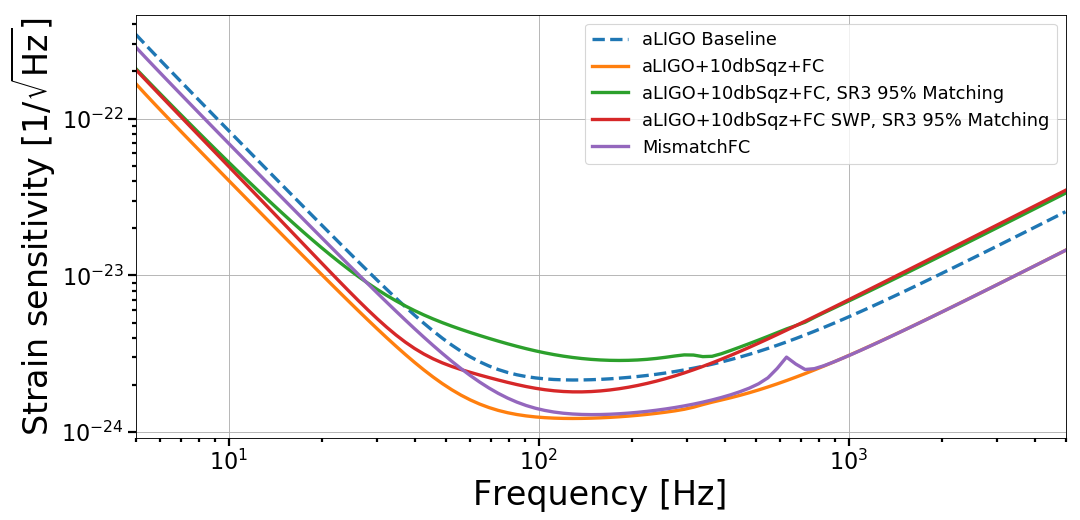

In [24]:
pl.figure(figsize=(15, 7), dpi=80)
pl.subplot(111)

pl.loglog(out_perfect_mm.x, out_perfect_mm_nosqz['NSR_with_RP'],'--',linewidth=3,\
          label='aLIGO Baseline')

pl.loglog(out_perfect_mm.x, out_perfect_mm['NSR_with_RP'],linewidth=3,\
          label='aLIGO+10dbSqz+FC')

pl.loglog(out_varySR3.x, out_varySR3['NSR_with_RP'],linewidth=3,\
          label='aLIGO+10dbSqz+FC, SR3 95% Matching')

pl.loglog(out_varySR3_FCswp.x, out_varySR3_FCswp['NSR_with_RP'],linewidth=3, \
          label='aLIGO+10dbSqz+FC SWP, SR3 95% Matching')

pl.loglog(out_varySR3_FCswp.x, out_mismatch_FC['NSR_with_RP'],linewidth=3, \
          label='MismatchFC')


pl.xlim(out_perfect_mm.x.min(),out_perfect_mm.x.max())
#pl.ylim(3e-25,1e-22)

pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=16)

pl.show()